<h2>Importing Data<h2>

In [373]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [374]:
df1 = pd.read_json('./Datasets/generated_data_Economics.json')
df2 = pd.read_csv('./Datasets/VOO.csv')

<h2>Preparing The Stock Price<h2>

In [375]:
df2['list_time'] = df2['Unnamed: 0'].str.split(" ")
df2['date'] = df2['list_time'].str[0]
df2['date'] =  pd.to_datetime(df2['date'])
df2['time'] = df2['list_time'].str[1].str.split("-").str[0]
df2.rename(columns={'Adj Close': 'price'}, inplace=True)
df2.head(5)

,Unnamed: 0,price,list_time,date,time
0,2022-08-29 09:30:00-04:00,369.648010,"[2022-08-29, 09:30:00-04:00]",2022-08-29,09:30:00
1,2022-08-29 09:31:00-04:00,369.799988,"[2022-08-29, 09:31:00-04:00]",2022-08-29,09:31:00
2,2022-08-29 09:33:00-04:00,370.220001,"[2022-08-29, 09:33:00-04:00]",2022-08-29,09:33:00
3,2022-08-29 09:34:00-04:00,370.549988,"[2022-08-29, 09:34:00-04:00]",2022-08-29,09:34:00
4,2022-08-29 09:35:00-04:00,370.299988,"[2022-08-29, 09:35:00-04:00]",2022-08-29,09:35:00


In [376]:
df2 = df2[['date', 'time', 'price']]
df2 = df2.groupby('date').agg(list)
df2['time_price'] = df2.apply(lambda row : dict(zip(row[0],row[1])), axis=1)
df2.head(5)

,time,price,time_price
date,,,
2022-08-29,"[09:30:00, 09:31:00, 09:33:00, 09:34:00, 09:35...","[369.6480102539063, 369.7999877929688, 370.220...","{'09:30:00': 369.6480102539063, '09:31:00': 36..."
2022-08-30,"[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[371.2200012207031, 370.760009765625, 371.0400...","{'09:30:00': 371.2200012207031, '09:31:00': 37..."
2022-08-31,"[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[367.0400085449219, 367.0700073242188, 366.660...","{'09:30:00': 367.0400085449219, '09:31:00': 36..."
2022-09-01,"[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[361.5299987792969, 360.8349914550781, 360.959...","{'09:30:00': 361.5299987792969, '09:31:00': 36..."
2022-09-02,"[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[367.3999938964844, 366.8800048828125, 366.709...","{'09:30:00': 367.3999938964844, '09:31:00': 36..."


<h2>Visualizing Trends In News Sentiment and Stock Prices<h2>

In [443]:
import helper

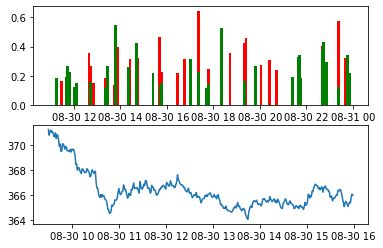

In [444]:
plot_x_days(1)

<AxesSubplot:>

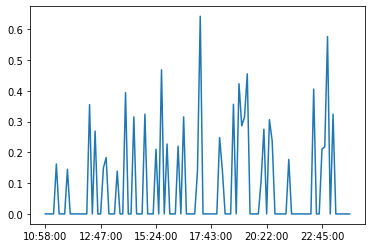

In [ ]:
def generate_day_frame(row, subreddit):
    df = pd.DataFrame.from_dict(row[subreddit], orient='index')
    return df

#df = pd.DataFrame.from_dict(df1.iloc[0]['Economics'], orient='index')
df = generate_day_frame(df1.iloc[0], 'Economics')
df.head()
df['neg'].plot.line()

<h3>Initial Hypothesis<h3>
<p>blah blah blah<p>

<h2>Markov Chains<h2>

<h3>Nth Degree Markov Chains<h3>

<h3>Optimizing Nth Degree Markov Chains<h3>

<h2>Deep Neural Network<h2>

<h2>LSTM Networks<h2>